In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("reubensuju/celeb-df-v2")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/celeb-df-v2


In [3]:
!pip uninstall pytorch-lightning -y
!pip install torch==1.13.1 torchvision==0.14.1
!pip install pytorch-lightning==1.9.5
!pip install facenet-pytorch==2.5.3
!pip install efficientnet-pytorch==0.7.1
!pip install albumentations==1.3.1
!pip install opencv-python==4.9.0.80
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.8.4
!pip install scikit-learn==1.4.2
!pip install tqdm==4.66.2

Found existing installation: pytorch-lightning 1.9.5
Uninstalling pytorch-lightning-1.9.5:
  Successfully uninstalled pytorch-lightning-1.9.5
  Using cached torch-1.13.1-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.15.0
ERROR: Could not find a version that satisfies the requirement torchvision==0.14.1 (from versions: 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0, 0.22.0)
ERROR: No matching distribution found for torchvision==0.14.1
  Using cached pytorch_lightning-1.9.5-py3-none-any.whl.metadata (23 kB)
Using cached pytorch_lightning-1.9.5-py3-none-any.whl (829 kB)


In [4]:
import torch
import pytorch_lightning
print(f"PyTorch: {torch.__version__}")
print(f"PyTorch Lightning: {pytorch_lightning.__version__}")

PyTorch: 2.5.1+cu124
PyTorch Lightning: 1.9.5


In [10]:
# Cell 01: Imports and Setup
import os
import gc
import cv2
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from scipy.ndimage import gaussian_filter1d

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
from facenet_pytorch import MTCNN
from efficientnet_pytorch import EfficientNet
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Memory management
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

Using device: cuda


32531

Processing real videos:   0%|          | 0/590 [00:00<?, ?it/s]

Processing fake videos:   0%|          | 0/5639 [00:00<?, ?it/s]

Train set: 4360 videos
Validation set: 934 videos
Test set: 935 videos


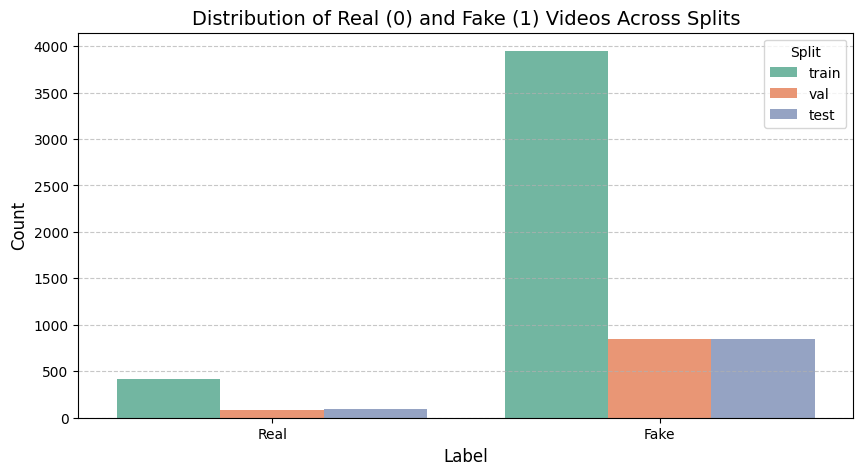

In [11]:
DATA_ROOT = '/kaggle/input/celeb-df-v2'
REAL_DIR = os.path.join(DATA_ROOT, 'Celeb-real')
FAKE_DIR = os.path.join(DATA_ROOT, 'Celeb-synthesis')

# Output directories
OUTPUT_DIR = '/kaggle/working/models'
PREPROCESSED_DIR = '/kaggle/working/preprocessed_faces'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(PREPROCESSED_DIR, exist_ok=True)

# Create dataset DataFrame
def create_dataset_df():
    data = []
    for video_name in tqdm(os.listdir(REAL_DIR), desc="Processing real videos"):
        if video_name.endswith('.mp4'):
            video_path = os.path.join(REAL_DIR, video_name)
            data.append({'video_path': video_path, 'label': 0, 'video_name': video_name})
    for video_name in tqdm(os.listdir(FAKE_DIR), desc="Processing fake videos"):
        if video_name.endswith('.mp4'):
            video_path = os.path.join(FAKE_DIR, video_name)
            data.append({'video_path': video_path, 'label': 1, 'video_name': video_name})
    
    df = pd.DataFrame(data)
    train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    
    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    print(f"Train set: {len(train_df)} videos")
    print(f"Validation set: {len(val_df)} videos")
    print(f"Test set: {len(test_df)} videos")
    
    return train_df, val_df, test_df

# Visualize data distribution
train_df, val_df, test_df = create_dataset_df()

plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=pd.concat([train_df.assign(split='train'), 
                                        val_df.assign(split='val'), 
                                        test_df.assign(split='test')]), 
              hue='split', palette='Set2')
plt.title('Distribution of Real (0) and Fake (1) Videos Across Splits', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Real', 'Fake'], fontsize=10)
plt.legend(title='Split', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(OUTPUT_DIR, 'data_distribution.png'))
plt.show()

Preprocessing training set...


Preprocessing /kaggle/working/preprocessed_faces/train:   0%|          | 0/4360 [00:00<?, ?it/s]

Skipped 0 existing files, processed 4360 new files
Total files in /kaggle/working/preprocessed_faces/train: 4360
Preprocessing validation set...


Preprocessing /kaggle/working/preprocessed_faces/val:   0%|          | 0/934 [00:00<?, ?it/s]

Skipped 0 existing files, processed 934 new files
Total files in /kaggle/working/preprocessed_faces/val: 934
Preprocessing test set...


Preprocessing /kaggle/working/preprocessed_faces/test:   0%|          | 0/935 [00:00<?, ?it/s]

Skipped 935 existing files, processed 0 new files
Total files in /kaggle/working/preprocessed_faces/test: 935


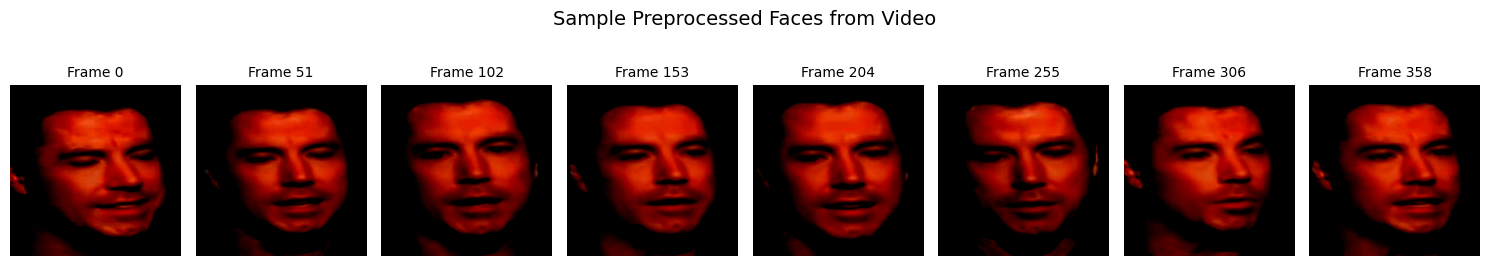

In [12]:
face_detector = MTCNN(
    image_size=160,
    margin=40,
    device=device,
    select_largest=True,
    post_process=True,
    keep_all=False
).to(device)

# Extract faces from video frames
def extract_faces_from_video(video_path, num_frames=8):
    faces = []
    frame_idxs = []
    
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if total_frames == 0:
        print(f"Warning: Could not open video {video_path}")
        return None, None
    
    if total_frames >= num_frames:
        frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)
    else:
        frame_indices = list(range(total_frames))
        while len(frame_indices) < num_frames:
            frame_indices.append(total_frames - 1)
    
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        
        if not ret:
            continue
            
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        try:
            face = face_detector(frame_rgb)
            if face is not None:
                faces.append(face)
                frame_idxs.append(idx)
        except Exception as e:
            print(f"Error processing frame {idx} in {video_path}: {e}")
            continue
    
    cap.release()
    
    if len(faces) == 0:
        return None, None
    
    while len(faces) < num_frames:
        if len(faces) > 0:
            faces.append(faces[-1])
            frame_idxs.append(frame_idxs[-1])
        else:
            break
    
    if len(faces) > 0:
        faces_tensor = torch.stack(faces[:num_frames])
        return faces_tensor, frame_idxs[:num_frames]
    else:
        return None, None

# Preprocess videos for train, validation, and test sets
def preprocess_videos(df, output_dir, num_frames=8):
    os.makedirs(output_dir, exist_ok=True)
    skipped = 0
    processed = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Preprocessing {output_dir}"):
        output_path = os.path.join(output_dir, f"{row['video_name']}.pt")
        if os.path.exists(output_path) and os.path.getsize(output_path) > 0:
            try:
                faces = torch.load(output_path, map_location='cpu')
                if faces.shape == (num_frames, 3, 160, 160):
                    skipped += 1
                    continue
            except Exception as e:
                print(f"Invalid file {output_path}: {e}")
        faces, _ = extract_faces_from_video(row['video_path'], num_frames)
        if faces is not None:
            torch.save(faces.cpu(), output_path)
            processed += 1
    print(f"Skipped {skipped} existing files, processed {processed} new files")
    print(f"Total files in {output_dir}: {len(os.listdir(output_dir))}")

# Preprocess all sets
train_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'train')
val_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'val')
test_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'test')

print("Preprocessing training set...")
preprocess_videos(train_df, train_preprocess_dir, num_frames=8)
print("Preprocessing validation set...")
preprocess_videos(val_df, val_preprocess_dir, num_frames=8)
print("Preprocessing test set...")
preprocess_videos(test_df, test_preprocess_dir, num_frames=8)

# Visualize sample preprocessed faces
sample_video = train_df.iloc[0]['video_path']
faces, frame_idxs = extract_faces_from_video(sample_video, num_frames=8)
if faces is not None:
    plt.figure(figsize=(15, 3))
    for i in range(min(8, len(faces))):
        plt.subplot(1, 8, i+1)
        plt.imshow(faces[i].permute(1, 2, 0).cpu().numpy())
        plt.title(f'Frame {frame_idxs[i]}', fontsize=10)
        plt.axis('off')
    plt.suptitle('Sample Preprocessed Faces from Video', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'sample_faces.png'))
    plt.show()

In [13]:
class FrequencyTransform:
    def __call__(self, img_tensor):
        img_np = img_tensor.permute(1, 2, 0).numpy()
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        f_transform = np.fft.fft2(gray)
        f_transform = np.fft.fftshift(f_transform)
        magnitude = np.log(np.abs(f_transform) + 1e-10)
        magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-10)
        return torch.FloatTensor(magnitude).unsqueeze(0)

# Data augmentation
def get_train_transforms():
    return A.Compose([
        A.OneOf([
            A.RandomBrightnessContrast(p=0.5),
            A.HueSaturationValue(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=0.25),
            A.GaussianBlur(blur_limit=5, p=0.25),
            A.GaussNoise(var_limit=(5.0, 30.0), p=0.25),
        ], p=0.25),
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=60, quality_upper=100, p=0.25),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([ToTensorV2()])

# Dataset class
class DeepfakeVideoDataset(Dataset):
    def __init__(self, df, transform=None, num_frames=8, preprocessed_dir=None):
        self.df = df
        self.transform = transform
        self.num_frames = num_frames
        self.freq_transform = FrequencyTransform()
        self.preprocessed_dir = preprocessed_dir
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx, retries=0):
        if retries > 10:
            raise RuntimeError(f"Failed to load valid data after 10 retries for index {idx}")
        
        video_path = self.df.iloc[idx]['video_path']
        label = self.df.iloc[idx]['label']
        video_name = self.df.iloc[idx]['video_name']
        
        faces = None
        if self.preprocessed_dir:
            preprocessed_path = os.path.join(self.preprocessed_dir, f"{video_name}.pt")
            if os.path.exists(preprocessed_path):
                try:
                    faces = torch.load(preprocessed_path, map_location='cpu')
                    if faces.shape != (self.num_frames, 3, 160, 160):
                        print(f"Invalid shape {faces.shape} in {preprocessed_path}")
                        faces = None
                except Exception as e:
                    print(f"Error loading {preprocessed_path}: {e}")
                    faces = None
        
        if faces is None:
            faces, _ = extract_faces_from_video(video_path, self.num_frames)
            if faces is not None and self.preprocessed_dir:
                preprocessed_path = os.path.join(self.preprocessed_dir, f"{video_name}.pt")
                torch.save(faces.cpu(), preprocessed_path)
        
        if faces is None:
            random_idx = random.randint(0, len(self) - 1)
            while random_idx == idx:
                random_idx = random.randint(0, len(self) - 1)
            return self.__getitem__(random_idx, retries + 1)
        
        if self.transform:
            transformed_faces = []
            for face in faces:
                face_np = face.permute(1, 2, 0).cpu().numpy()
                augmented = self.transform(image=face_np)
                transformed_face = augmented['image']
                transformed_faces.append(transformed_face)
            faces = torch.stack(transformed_faces)  # Keep on CPU
        else:
            faces = faces.cpu()  # Ensure faces are on CPU
        
        freq_features = []
        for face in faces:
            freq_features.append(self.freq_transform(face))  # face is on CPU
        
        freq_features = torch.stack(freq_features)  # Keep on CPU
        
        return {
            'faces': faces,  # CPU tensor
            'freq_features': freq_features,  # CPU tensor
            'label': torch.tensor(label, dtype=torch.float32)  # CPU tensor
        }


In [14]:
# Cell 05: Model Definition
# Lightweight DeepFake Detection Model
class LightweightDeepFakeDetector(nn.Module):
    def __init__(self, num_frames=8):
        super().__init__()
        self.spatial_encoder = EfficientNet.from_pretrained('efficientnet-b0')
        self.spatial_encoder._fc = nn.Identity()
        self.spatial_feature_dim = 1280
        
        self.freq_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        
        self.fusion_layer = nn.Linear(self.spatial_feature_dim + 32, 256)
        
        self.gru = nn.GRU(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)  # No sigmoid
        )
        
    def forward(self, faces, freq_features):
        batch_size, num_frames, channels, height, width = faces.shape
        faces_reshaped = faces.view(batch_size * num_frames, channels, height, width)
        spatial_features = self.spatial_encoder(faces_reshaped)
        spatial_features = spatial_features.view(batch_size, num_frames, -1)
        
        freq_reshaped = freq_features.view(batch_size * num_frames, 1, height, width)
        freq_encoded = self.freq_encoder(freq_reshaped)
        freq_encoded = freq_encoded.view(batch_size, num_frames, -1)
        
        concatenated_features = torch.cat([spatial_features, freq_encoded], dim=2)
        fused_features = self.fusion_layer(concatenated_features)
        
        gru_out, _ = self.gru(fused_features)
        sequence_repr = gru_out[:, -1, :]
        
        prediction = self.classifier(sequence_repr)
        return prediction


In [15]:

# Cell 06: PyTorch Lightning Module
class DeepFakeDetectorModule(pl.LightningModule):
    def __init__(self, model, learning_rate=1e-4):
        super().__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.save_hyperparameters(ignore=['model'])
        self.validation_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        self.val_aucs = []
        self.val_accs = []
        
    def forward(self, faces, freq_features):
        # Move inputs to device
        faces = faces.to(self.device)
        freq_features = freq_features.to(self.device)
        return self.model(faces, freq_features)
    
    def training_step(self, batch, batch_idx):
        faces = batch['faces'].to(self.device)
        freq_features = batch['freq_features'].to(self.device)
        labels = batch['label'].unsqueeze(1).to(self.device)
        
        predictions = self(faces, freq_features)
        loss = F.binary_cross_entropy_with_logits(predictions, labels)
        
        self.log('train_loss', loss, prog_bar=True)
        self.train_losses.append(loss.item())
        return loss
    
    def validation_step(self, batch, batch_idx):
        faces = batch['faces'].to(self.device)
        freq_features = batch['freq_features'].to(self.device)
        labels = batch['label'].unsqueeze(1).to(self.device)
        
        predictions = self(faces, freq_features)
        loss = F.binary_cross_entropy_with_logits(predictions, labels)
        
        binary_preds = (torch.sigmoid(predictions) > 0.5).float()
        acc = (binary_preds == labels).float().mean()
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        self.validation_step_outputs.append({'preds': predictions.cpu(), 'labels': labels.cpu()})
        self.val_losses.append(loss.item())
        self.val_accs.append(acc.item())
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        preds = torch.cat([x['preds'] for x in self.validation_step_outputs]).numpy()
        labels = torch.cat([x['labels'] for x in self.validation_step_outputs]).numpy()
        
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1:
            try:
                auc = roc_auc_score(labels, torch.sigmoid(torch.tensor(preds)).numpy())
                self.log('val_auc', auc, prog_bar=True)
                self.val_aucs.append(auc)
            except ValueError as e:
                print(f"Warning: Could not compute AUC: {e}")
                self.log('val_auc', 0.0, prog_bar=True)
                self.val_aucs.append(0.0)
        else:
            print(f"Warning: Only one class ({unique_labels}) present in validation data. Skipping AUC.")
            self.log('val_auc', 0.0, prog_bar=True)
            self.val_aucs.append(0.0)
        
        self.validation_step_outputs = []
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=1e-4
        )
        
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
        
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

In [16]:
def train_model(train_df, val_df, batch_size=4, num_frames=8, max_epochs=20):
    train_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'train')
    val_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'val')
    
    print(f"Using preprocessed training files: {train_preprocess_dir}")
    print(f"Total train files: {len(os.listdir(train_preprocess_dir))}")
    print(f"Using preprocessed validation files: {val_preprocess_dir}")
    print(f"Total val files: {len(os.listdir(val_preprocess_dir))}")
    
    train_dataset = DeepfakeVideoDataset(
        train_df,
        transform=get_train_transforms(),
        num_frames=num_frames,
        preprocessed_dir=train_preprocess_dir
    )
    
    real_val_count = (val_df['label'] == 0).sum()
    fake_val_count = (val_df['label'] == 1).sum()
    print(f"Validation set - Real: {real_val_count}, Fake: {fake_val_count}")
    
    sample_size = min(100, real_val_count, fake_val_count)
    if sample_size == 0:
        print("Error: No samples available for real or fake class in validation set.")
        return None
    
    real_val = val_df[val_df['label'] == 0].sample(sample_size, random_state=42)
    fake_val = val_df[val_df['label'] == 1].sample(sample_size, random_state=42)
    balanced_val_df = pd.concat([real_val, fake_val]).reset_index(drop=True)
    
    print(f"Balanced validation set: {len(balanced_val_df)} videos")
    print(f"Balanced validation labels: {balanced_val_df['label'].value_counts().to_dict()}")
    
    val_dataset = DeepfakeVideoDataset(
        balanced_val_df,
        transform=get_val_transforms(),
        num_frames=num_frames,
        preprocessed_dir=val_preprocess_dir
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True,  # Safe with CPU tensors
        drop_last=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=min(16, len(val_dataset)),
        shuffle=False,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True  # Safe with CPU tensors
    )
    
    model = LightweightDeepFakeDetector(num_frames=num_frames)
    model_module = DeepFakeDetectorModule(model=model, learning_rate=1e-4)
    
    checkpoint_callback = ModelCheckpoint(
        monitor='val_auc',
        dirpath=OUTPUT_DIR,
        filename='deepfake-{epoch:02d}-{val_auc:.4f}',
        save_top_k=1,
        mode='max'
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_auc',
        patience=3,
        mode='max'
    )
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        gpus=1 if torch.cuda.is_available() else 0,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10,
        precision=16,
        num_sanity_val_steps=4
    )
    
    try:
        trainer.fit(model_module, train_loader, val_loader)
        best_path = checkpoint_callback.best_model_path
        print(f"Best model saved at: {best_path}")
        
        # Visualize training metrics with smoothing
        plt.figure(figsize=(15, 5))
        
        # Smooth curves for better visualization
        smoothed_train_loss = gaussian_filter1d(model_module.train_losses, sigma=2)
        smoothed_val_loss = gaussian_filter1d(model_module.val_losses, sigma=2)
        smoothed_val_auc = gaussian_filter1d(model_module.val_aucs, sigma=1)
        smoothed_val_acc = gaussian_filter1d(model_module.val_accs, sigma=1)
        
        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(model_module.train_losses, 'b-', alpha=0.3, label='Train Loss (Raw)')
        plt.plot(smoothed_train_loss, 'b-', label='Train Loss (Smoothed)')
        plt.plot(model_module.val_losses, 'r-', alpha=0.3, label='Val Loss (Raw)')
        plt.plot(smoothed_val_loss, 'r-', label='Val Loss (Smoothed)')
        plt.title('Training and Validation Loss', fontsize=12)
        plt.xlabel('Steps', fontsize=10)
        plt.ylabel('Loss', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # AUC plot
        plt.subplot(1, 3, 2)
        plt.plot(model_module.val_aucs, 'g-', alpha=0.3, label='Val AUC (Raw)')
        plt.plot(smoothed_val_auc, 'g-', label='Val AUC (Smoothed)')
        plt.title('Validation AUC', fontsize=12)
        plt.xlabel('Epochs', fontsize=10)
        plt.ylabel('AUC', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Accuracy plot
        plt.subplot(1, 3, 3)
        plt.plot(model_module.val_accs, 'm-', alpha=0.3, label='Val Accuracy (Raw)')
        plt.plot(smoothed_val_acc, 'm-', label='Val Accuracy (Smoothed)')
        plt.title('Validation Accuracy', fontsize=12)
        plt.xlabel('Epochs', fontsize=10)
        plt.ylabel('Accuracy', fontsize=10)
        plt.legend(fontsize=8)
        plt.grid(True, linestyle='--', alpha=0.7)
        
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, 'training_metrics.png'))
        plt.show()
        
    except Exception as e:
        print(f"Training failed: {e}")
        return None
    
    return best_path

In [17]:
def evaluate_model(model_path, test_df, batch_size=4, num_frames=8):
    if not model_path or not os.path.isfile(model_path):
        print(f"Error: Invalid model path '{model_path}'. Training may have failed.")
        return None
    
    test_preprocess_dir = os.path.join(PREPROCESSED_DIR, 'test')
    print(f"Using preprocessed test files: {test_preprocess_dir}")
    print(f"Total test files: {len(os.listdir(test_preprocess_dir))}")
    
    model_module = DeepFakeDetectorModule.load_from_checkpoint(
        model_path,
        model=LightweightDeepFakeDetector(num_frames=num_frames)
    )
    
    model_module.eval()
    model_module.to(device)
    
    test_dataset = DeepfakeVideoDataset(
        test_df,
        transform=get_val_transforms(),
        num_frames=num_frames,
        preprocessed_dir=test_preprocess_dir
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,  # Set to 0 to avoid multiprocessing issues
        pin_memory=True  # Safe with CPU tensors
    )
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            faces = batch['faces'].to(device)
            freq_features = batch['freq_features'].to(device)
            labels = batch['label'].unsqueeze(1).to(device)
            
            predictions = model_module(faces, freq_features)
            
            all_preds.append(torch.sigmoid(predictions).cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    
    # Calculate metrics
    auc = roc_auc_score(all_labels, all_preds)
    binary_preds = (all_preds > 0.5).astype(int)
    acc = accuracy_score(all_labels, binary_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, binary_preds, average='binary')
    cm = confusion_matrix(all_labels, binary_preds)
    
    # Calculate EER
    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    fnr = 1 - tpr
    eer_threshold = thresholds[np.argmin(np.abs(fpr - fnr))]
    eer = fpr[np.argmin(np.abs(fpr - fnr))]
    
    print(f"Test Results:")
    print(f"AUC: {auc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}")
    print(f"Confusion Matrix:\n{cm}")
    
    # Enhanced visualizations
    plt.figure(figsize=(15, 10))
    
    # ROC Curve with EER
    plt.subplot(2, 2, 1)
    plt.plot(fpr, tpr, lw=2, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.plot([eer, eer], [0, 1], 'r--', lw=2, label=f'EER = {eer:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=10)
    plt.ylabel('True Positive Rate', fontsize=10)
    plt.title('Receiver Operating Characteristic', fontsize=12)
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Confusion Matrix
    plt.subplot(2, 2, 2)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=12)
    plt.xlabel('Predicted', fontsize=10)
    plt.ylabel('True', fontsize=10)
    plt.xticks([0.5, 1.5], ['Real', 'Fake'], fontsize=8)
    plt.yticks([0.5, 1.5], ['Real', 'Fake'], fontsize=8)
    
    # Metrics Bar Plot
    metrics = {'AUC': auc, 'Accuracy': acc, 'F1 Score': f1, 'Precision': precision, 'Recall': recall, 'EER': eer}
    plt.subplot(2, 2, 3)
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='Set2')
    plt.title('Evaluation Metrics', fontsize=12)
    plt.ylabel('Score', fontsize=10)
    plt.ylim(0, 1)
    for i, v in enumerate(metrics.values()):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Prediction Distribution Histogram
    plt.subplot(2, 2, 4)
    plt.hist(all_preds[all_labels == 0], bins=30, alpha=0.5, label='Real', color='blue')
    plt.hist(all_preds[all_labels == 1], bins=30, alpha=0.5, label='Fake', color='red')
    plt.axvline(x=0.5, color='black', linestyle='--', label='Threshold (0.5)')
    plt.title('Prediction Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Count', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'evaluation_metrics.png'))
    plt.show()
    
    return {
        'auc': auc,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'eer': eer,
        'confusion_matrix': cm
    }


Starting preprocessing and training...
Using preprocessed training files: /kaggle/working/preprocessed_faces/train
Total train files: 4360
Using preprocessed validation files: /kaggle/working/preprocessed_faces/val
Total val files: 934
Validation set - Real: 88, Fake: 846
Balanced validation set: 176 videos
Balanced validation labels: {0: 88, 1: 88}
Loaded pretrained weights for efficientnet-b0


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Best model saved at: /kaggle/working/models/deepfake-epoch=03-val_auc=1.0000.ckpt


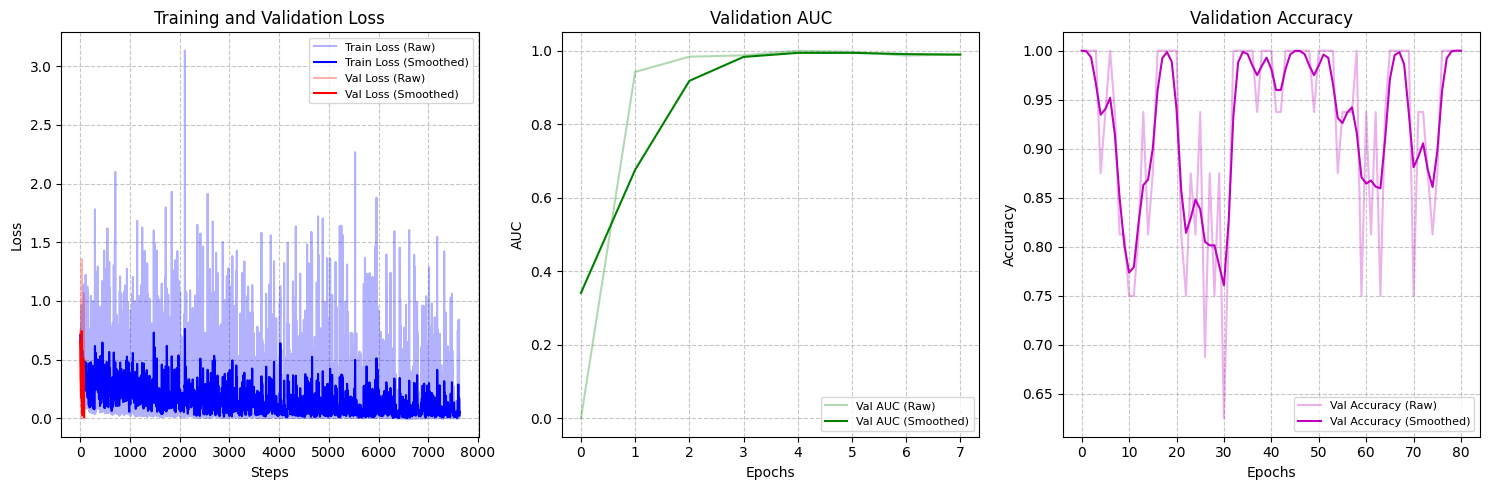

Evaluating model from /kaggle/working/models/deepfake-epoch=03-val_auc=1.0000.ckpt...
Using preprocessed test files: /kaggle/working/preprocessed_faces/test
Total test files: 935
Loaded pretrained weights for efficientnet-b0


Evaluating:   0%|          | 0/234 [00:00<?, ?it/s]

Test Results:
AUC: 0.9940
Accuracy: 0.9733
F1 Score: 0.9851
Precision: 0.9916
Recall: 0.9787
Equal Error Rate (EER): 0.0337
Confusion Matrix:
[[ 82   7]
 [ 18 828]]


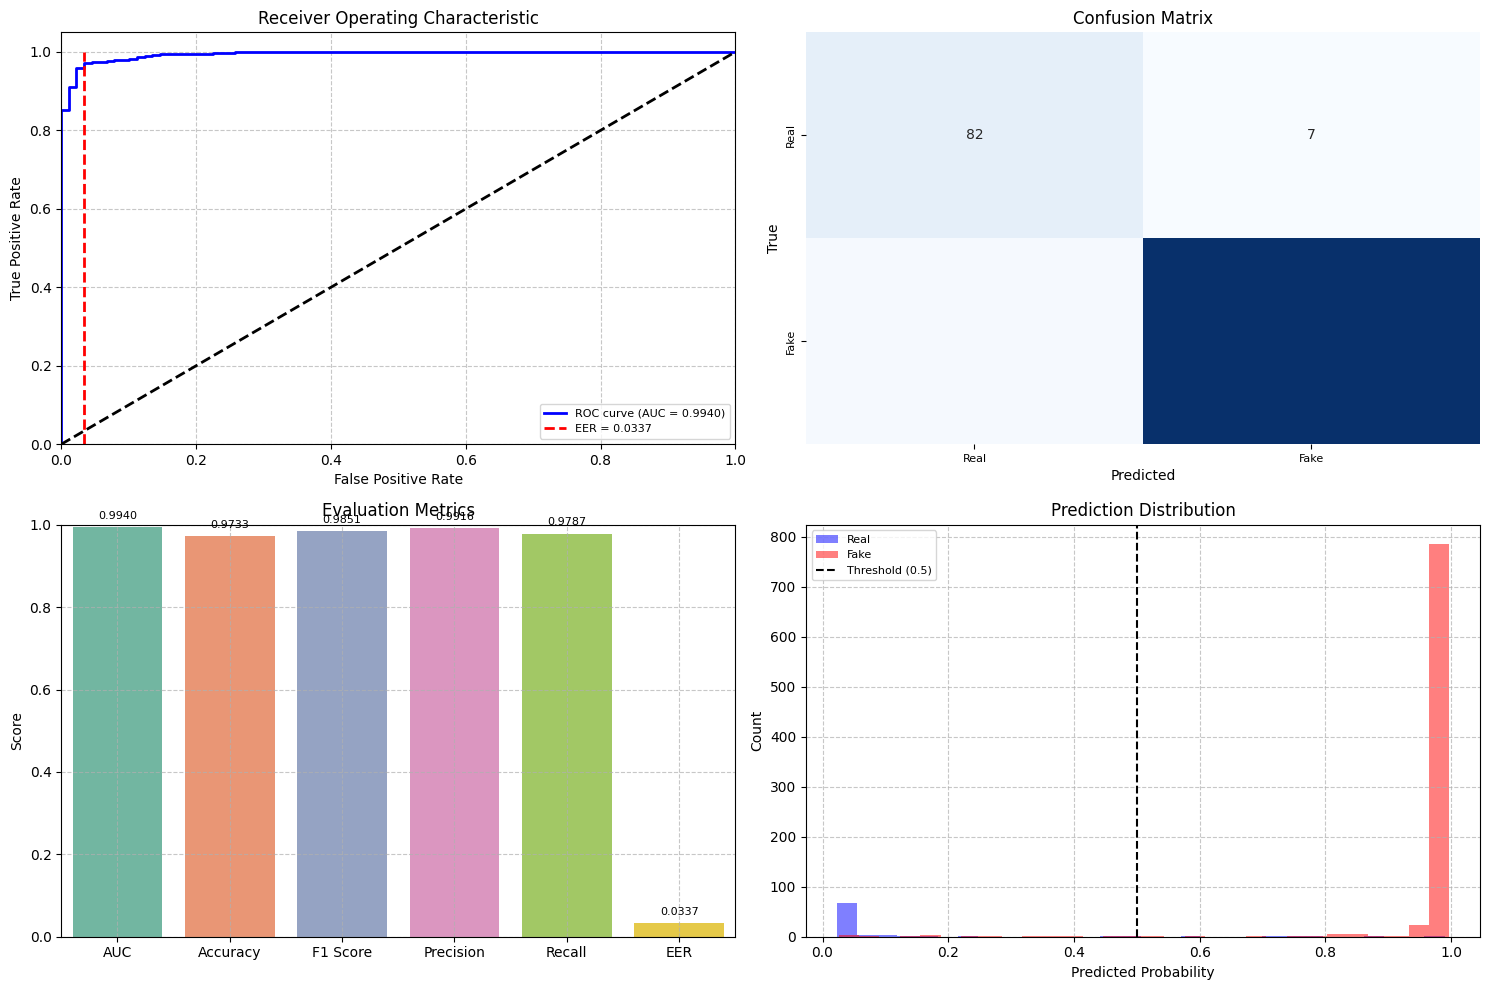

Completed!


In [20]:
# Cell 09: Main Execution
if __name__ == "__main__":
    print("Starting preprocessing and training...")
    best_model_path = train_model(
        train_df,
        val_df,
        batch_size=4,
        num_frames=8,
        max_epochs=20
    )
    
    print(f"Evaluating model from {best_model_path}...")
    metrics = evaluate_model(
        best_model_path,
        test_df,
        batch_size=4,
        num_frames=8
    )
    
    print("Completed!")